# ENTRENAMIENTO MODELO DE CLASIFICACIÓN MULTICLASE.


#### Autor: Víctor Barcina Muñoz

### Entrenamiento del modelo. Arquitectura ResNet50


In [1]:
# Se cargan las librerías necesarias
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np
import tensorflow as tf

'''
Para entrenar el modelo se va a emplear Transfer Learning, es decir, se va a aprovechar el conocimiento adquirido de un entrenamiento ya realizado
para mejorar el rendimiento del nuestro. La arquitectura empleada es ResNet50. 

En primer lugar es necesario definir el modelo preentrenado para su uso (ResNet50).
ResNet es un modelo de red neuronal profunda conocido por su efectividad en tareas de clasificación de imágenes. Sus características principales son:
- **Bloques Residuales**: Utiliza bloques residuales para permitir el aprendizaje de funciones de identidad, lo que facilita el entrenamiento de redes más profundas.
- **Pooling**: En la arquitectura de ResNet50, se aplica **Average Pooling** en lugar de Max Pooling, lo que ayuda a mantener información más rica de la imagen.
- **Capas Fully Connected (Dense)**: A la salida de las capas convolucionales, el modelo original de ResNet50 contiene:
  - Una capa densa con 1000 neuronas (una por cada clase en ImageNet) con función de activación Softmax, que convierte los valores en probabilidades que suman 1.

## Preprocesamiento de las Imágenes
Las imágenes de entrada deben ser de tamaño (224x224) píxeles y deben ser preprocesadas antes de ser alimentadas al modelo. Esto incluye la
normalización de los valores RGB, donde se resta la media de los píxeles del conjunto de datos de entrenamiento de ImageNet. Esto asegura que los
datos de entrada sean consistentes con los datos en los que fue entrenado el modelo ResNet50.

## Parámetros Importantes
El script incluye varios parámetros clave que deben ser configurados manualmente:
- **`weights`**: Se establece como 'imagenet' para utilizar los pesos preentrenados del modelo ResNet50.
- **`include_top`**: Se establece en `False` para excluir la parte final del modelo, permitiendo la personalización para un nuevo conjunto de clases.
- **`input_shape`**: Se define como `(224, 224, 3)` para indicar el tamaño de las imágenes de entrada y que el modelo espera imágenes RGB.

## Entrenamiento del Modelo
Durante el entrenamiento, se aprovechan los pesos preentrenados de ResNet50, ajustando las capas finales para adaptarlas a un nuevo conjunto de clases. 
En este caso, se añaden capas densas que clasifican las imágenes en tres clases:
- **Melanoma (mel)**
- **Carcinoma Basocelular (bcc)**
- **Carcinoma Espinocelular (bkl)**

### Detalles del Entrenamiento
- **Aumento de Datos**: Se utiliza `ImageDataGenerator` para realizar aumentos en las imágenes de entrenamiento, como rotaciones,
desplazamientos y volteos, lo que ayuda a mejorar la generalización del modelo.
- **Cálculo de Pesos de Clase**: Se calculan pesos de clase para compensar el desequilibrio en el conjunto de datos, asegurando que las clases menos
representadas tengan mayor peso durante el entrenamiento.
- **Callbacks**: Se implementan varias funciones de callback para optimizar el proceso de entrenamiento:
  - **EarlyStopping**: Detiene el entrenamiento si no hay mejora en la pérdida de validación después de un número definido de épocas.
  - **ReduceLROnPlateau**: Reduce la tasa de aprendizaje si la mejora en la pérdida de validación se estanca.
  - **ModelCheckpoint**: Guarda el modelo cuando se observa una mejora en la pérdida de validación.

## Evaluación del Modelo
Después del entrenamiento, se evalúa la precisión del modelo en las clases específicas, proporcionando una visión detallada de su rendimiento y 
permitiendo ajustes si es necesario.

Este enfoque no solo permite aprovechar la potencia de un modelo previamente entrenado, sino que también facilita la adaptación a nuevas tareas de
clasificación de imágenes de manera eficiente y efectiva
'''

# Definición del modelo base ResNet50
# Pesos de ImageNet
# Exclusión de la capa final del modelo para reemplazarlas por las nuestras
# Tamaño de imágenes y canal RGB
modelo_preentrenado = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Descongelamos las últimas capas de ResNet50 para fine-tuning controlado
for capa in modelo_preentrenado.layers[:-10]:  
    capa.trainable = False

# Capas adicionales para clasificación
salida_base = modelo_preentrenado.output  # Obtenemos la salida de la última capa del modelo preentrenado
salida_pooled = GlobalAveragePooling2D()(salida_base)  # Reduce sobreajuste reduciendo la dimensionalidad del volumen de características
salida_densa_1 = Dense(256, activation='relu')(salida_pooled)  # capa de neuronas con función relu para propagar valores positivos
salida_dropout_1 = Dropout(0.3)(salida_densa_1)  # Regularización para prevenir sobreajuste
salida_densa_2 = Dense(128, activation='relu')(salida_dropout_1)  # capa de neuronas con función relu para propagar valores positivos
salida_dropout_2 = Dropout(0.3)(salida_densa_2)  # Regularización para prevenir sobreajuste
salida_final = Dense(3, activation='softmax')(salida_dropout_2)  # Capa final Dense con 3 neuronas. Predicción de tres clases: mel, bcc, bkl
# Definimos el modelo final, que toma la entrada de ResNet50 y produce la salida final definida
modelo = Model(inputs=modelo_preentrenado.input, outputs=salida_final)

# Compilación del modelo con un learning rate bajo
modelo.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Aumento de datos con ImageDataGenerator
generador_entrenamiento = ImageDataGenerator(
    rotation_range=20,  # rotación
    width_shift_range=0.1,  # desplazamiento horizontal
    height_shift_range=0.1,  # desplazamiento vertical
    zoom_range=0.2,  # zoom
    horizontal_flip=True,  # volteo de imagen
    fill_mode='nearest'  # Relleno de píxeles
)
generador_validacion = ImageDataGenerator()  # no hay aumentos para que las imágenes sean iguales a las del entrenamiento

# Configuración de generadores con balance de clases para cargar imágenes de las carpetas de entrenamiento
generador_imagenes_entrenamiento = generador_entrenamiento.flow_from_directory(
    './train',
    target_size=(224, 224),  # dimensiones de la imagen
    batch_size=16,  # Número de imágenes procesadas simultáneamente
    class_mode='categorical',
    classes=['mel', 'bcc', 'bkl']
)
generador_imagenes_validacion = generador_validacion.flow_from_directory(
    './val',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    classes=['mel', 'bcc', 'bkl']
)

# Calcular pesos de clase para compensar el desequilibrio
contar_clases = generador_imagenes_entrenamiento.classes
# Calculamos pesos de cada clase de manera que estén balanceadas. Las clases menos representadas tendrán más valor, y viceversa
pesos_clase_balanceados = class_weight.compute_class_weight('balanced', classes=np.unique(contar_clases), y=contar_clases)
# Creamos un diccionario donde cada clave representa las clases, y los valores sus pesos asignados. 
diccionario_pesos_clase = {i: pesos_clase_balanceados[i] for i in range(3)}

# Callbacks para optimización del modelo
# Detiene el entrenamiento si el rendimiento (val_loss) no mejora tras 10 épocas.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
# Reduce tasa de aprendizaje si la mejora en val_loss se estanca
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
# Guarda el modelo cuando se observa una mejora
model_checkpoint = ModelCheckpoint('Modelo_ResNet50_VBM.keras', save_best_only=True, monitor='val_loss', mode='min')

# Función personalizada para mostrar precisión de cada clase
class CallbackMetricasPersonalizadas(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        predicciones_validacion = np.argmax(self.model.predict(generador_imagenes_validacion), axis=-1)
        etiquetas_reales = generador_imagenes_validacion.classes
        precision_clase = {}
        
        for i, nombre_clase in enumerate(['mel', 'bcc', 'bkl']):
            verdaderos_positivos = np.sum((predicciones_validacion == i) & (etiquetas_reales == i))
            total_imagenes_clase = np.sum(etiquetas_reales == i)
            precision = verdaderos_positivos / total_imagenes_clase if total_imagenes_clase > 0 else 0
            precision_clase[nombre_clase] = precision * 100
            print(f'Precisión para {nombre_clase} en época {epoch + 1}: {precision_clase[nombre_clase]:.2f}%')
        print("")

# Entrenamos el modelo con los generadores y callbacks definidos
history = modelo.fit(
    generador_imagenes_entrenamiento,
    steps_per_epoch=generador_imagenes_entrenamiento.samples // generador_imagenes_entrenamiento.batch_size,
    validation_data=generador_imagenes_validacion,
    validation_steps=generador_imagenes_validacion.samples // generador_imagenes_validacion.batch_size,
    epochs=50,  # Ajustar según sea necesario
    class_weight=diccionario_pesos_clase,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, CallbackMetricasPersonalizadas()]
)
# Mostrar la precisión final por clase
print("Final precision by class:")
prediccion_final = np.argmax(modelo.predict(generador_imagenes_validacion), axis=-1)
etiquetas_reales_finales = generador_imagenes_validacion.classes
for i, class_name in enumerate(['mel', 'bcc', 'bkl']):
    verdaderos_positivos = np.sum((prediccion_final == i) & (etiquetas_reales_finales == i))
    total_imagenes_clase = np.sum(etiquetas_reales_finales == i)
    precision = verdaderos_positivos / total_imagenes_clase if total_imagenes_clase > 0 else 0
    print(f"Precisión para {class_name}: {precision * 100:.2f}%")



Found 1907 images belonging to 3 classes.
Found 409 images belonging to 3 classes.
Epoch 1/50


C:\Users\victo\anaconda3\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step
Precisión para mel en época 1: 42.51%
Precisión para bcc en época 1: 14.29%
Precisión para bkl en época 1: 53.33%

119/119 ━━━━━━━━━━━━━━━━━━━━ 453s 3s/step - accuracy: 0.3686 - loss: 1.3147 - val_accuracy: 0.5125 - val_loss: 0.9865 - learning_rate: 1.0000e-05
Epoch 2/50
  1/119 ━━━━━━━━━━━━━━━━━━━━ 4:14 2s/step - accuracy: 0.1250 - loss: 1.2084

C:\Users\victo\anaconda3\anaconda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


26/26 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step
Precisión para mel en época 2: 38.32%
Precisión para bcc en época 2: 10.39%
Precisión para bkl en época 2: 49.09%

119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 498ms/step - accuracy: 0.1250 - loss: 1.2084 - val_accuracy: 0.4444 - val_loss: 0.9903 - learning_rate: 1.0000e-05
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step
Precisión para mel en época 3: 58.08%
Precisión para bcc en época 3: 11.69%
Precisión para bkl en época 3: 29.09%

119/119 ━━━━━━━━━━━━━━━━━━━━ 375s 3s/step - accuracy: 0.4070 - loss: 1.1888 - val_accuracy: 0.5250 - val_loss: 0.9420 - learning_rate: 1.0000e-05
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step
Precisión para mel en época 4: 54.49%
Precisión para bcc en época 4: 18.18%
Precisión para bkl en época 4: 27.88%

119/119 ━━━━━━━━━━━━━━━━━━━━ 59s 485ms/step - accuracy: 0.3750 - loss: 1.1253 - val_accuracy: 1.0000 - val_loss: 0.6642 - learning_rate: 1.0000e-05
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step
Precisión para mel en ép

### PRUEBAS DEL MODELO ResNet50


Resultados para la clase 'mel':
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
  Imagen: ISIC_0024313.jpg - Predicción: mel (Confianza: 0.57), Correcta: True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
  Imagen: ISIC_0024516.jpg - Predicción: mel (Confianza: 0.70), Correcta: True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
  Imagen: ISIC_0024546.jpg - Predicción: mel (Confianza: 0.65), Correcta: True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
  Imagen: ISIC_0024552.jpg - Predicción: mel (Confianza: 0.88), Correcta: True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
  Imagen: ISIC_0024640.jpg - Predicción: mel (Confianza: 0.98), Correcta: True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
  Imagen: ISIC_0024647.jpg - Predicción: bkl (Confianza: 0.61), Correcta: False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
  Imagen: ISIC_0024675.jpg - Predicción: mel (Confianza: 0.54), Correcta: True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
  Imagen: ISIC_0024700.jpg - Predicción: mel (Confianza: 0.87), Correcta: True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9

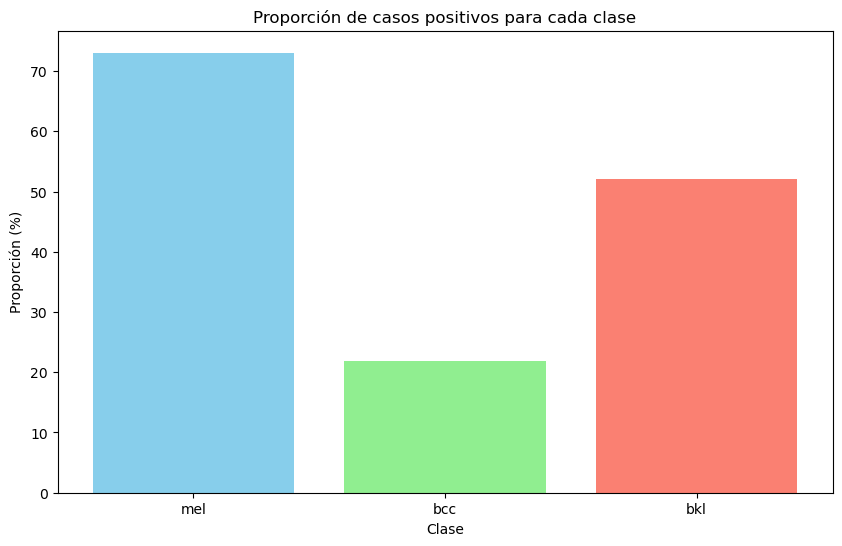

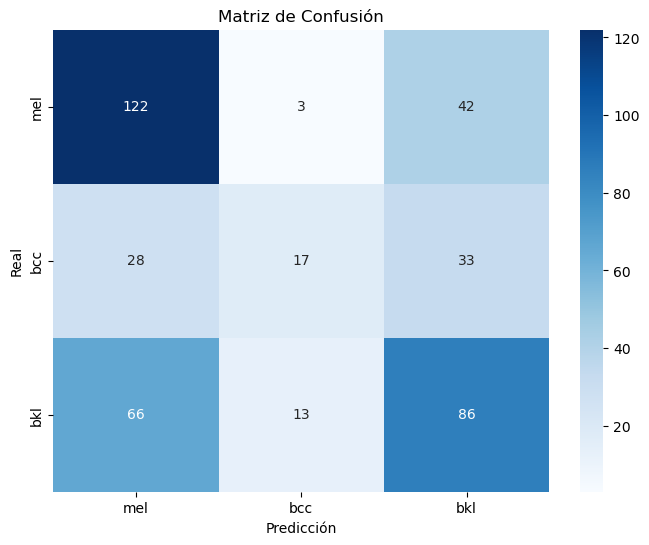


Para la clase 'mel':
  - Verdaderos Positivos (TP): 122
  - Verdaderos Negativos (TN): 149
  - Falsos Positivos (FP): 94
  - Falsos Negativos (FN): 45
  - Exactitud (Accuracy): 66.10%
  - Sensibilidad (Recall): 73.05%
  - Especificidad: 61.32%
  - Precisión: 56.48%

Para la clase 'bcc':
  - Verdaderos Positivos (TP): 17
  - Verdaderos Negativos (TN): 316
  - Falsos Positivos (FP): 16
  - Falsos Negativos (FN): 61
  - Exactitud (Accuracy): 81.22%
  - Sensibilidad (Recall): 21.79%
  - Especificidad: 95.18%
  - Precisión: 51.52%

Para la clase 'bkl':
  - Verdaderos Positivos (TP): 86
  - Verdaderos Negativos (TN): 170
  - Falsos Positivos (FP): 75
  - Falsos Negativos (FN): 79
  - Exactitud (Accuracy): 62.44%
  - Sensibilidad (Recall): 52.12%
  - Especificidad: 69.39%
  - Precisión: 53.42%


In [12]:
#librerias necesarias
import os  
import matplotlib.pyplot as plt  
from tensorflow.keras.models import load_model 
from tensorflow.keras.preprocessing import image  
from tensorflow.keras.applications.vgg16 import preprocess_input  
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np  

# Cargar el modelo previamente guardado
modelo = load_model('Modelo_ResNet50_VBM.keras')

# Definir las etiquetas de clase
etiquetas_clase = {0: 'mel', 1: 'bcc', 2: 'bkl'}

tamaño_imagen = (224, 224)  # Tamaño de imagen requerido por el modelo VGG16

# Definir los directorios de imágenes de prueba organizadas por clase
directorios_prueba = {
    'mel': 'test/mel',
    'bcc': 'test/bcc',
    'bkl': 'test/bkl'
}

# Función para evaluar múltiples imágenes de cada clase
def evaluar_imagenes_multiples(modelo, directorios_prueba):
    resultados = {}  # Diccionario para almacenar resultados de precisión por clase
    todas_las_predicciones = []  # Lista para almacenar resultados de cada imagen

    # Iterar sobre cada clase y su carpeta correspondiente
    for etiqueta, carpeta in directorios_prueba.items():
        archivos_imagen = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if os.path.isfile(os.path.join(carpeta, f))]
        
        aciertos_correctos = 0  # Contador para las predicciones correctas
        total_predicciones = len(archivos_imagen)  # Total de imágenes a evaluar
        
        print(f"\nResultados para la clase '{etiqueta}':")

        # Evaluar cada imagen en la carpeta correspondiente
        for ruta_imagen in archivos_imagen:
            # Cargar y preprocesar la imagen
            img = image.load_img(ruta_imagen, target_size=tamaño_imagen)
            array_imagen = image.img_to_array(img)  # Convertir la imagen a un arreglo de numpy
            array_imagen = np.expand_dims(array_imagen, axis=0)  # Agregar una dimensión para el lote
            array_imagen = preprocess_input(array_imagen)  # Preprocesar la imagen según el modelo VGG16
            
            # Realizar la predicción
            prediccion = modelo.predict(array_imagen)
            indice_clase_predicha = np.argmax(prediccion, axis=1)[0]  # Obtener el índice de la clase predicha
            etiqueta_clase_predicha = etiquetas_clase.get(indice_clase_predicha, "Desconocido")  # Obtener la etiqueta correspondiente
            probabilidad_predicha = prediccion[0][indice_clase_predicha]  # Obtener la probabilidad de la predicción

            # Comparar la predicción con la clase esperada
            correcto = (etiqueta_clase_predicha == etiqueta)  # Verificar si la predicción es correcta
            if correcto:
                aciertos_correctos += 1  # Incrementar el contador si la predicción es correcta

            # Agregar la predicción a los resultados generales
            todas_las_predicciones.append({
                'ruta': ruta_imagen,
                'clase_real': etiqueta,
                'clase_predicha': etiqueta_clase_predicha,
                'probabilidad': probabilidad_predicha,
                'correcta': correcto
            })

            # Imprimir el resultado de la imagen actual
            print(f"  Imagen: {os.path.basename(ruta_imagen)} - Predicción: {etiqueta_clase_predicha} "
                  f"(Confianza: {probabilidad_predicha:.2f}), Correcta: {correcto}")

        # Calcular precisión para la clase actual
        precision = (aciertos_correctos / total_predicciones) * 100 if total_predicciones > 0 else 0
        resultados[etiqueta] = {
            'precision': precision,
            'correctas': aciertos_correctos,
            'total': total_predicciones
        }
    
    return resultados, todas_las_predicciones

# Función para calcular y mostrar la matriz de confusión y métricas de rendimiento
def mostrar_matriz_confusion(todas_las_predicciones):
    # Extraer las clases reales y predichas
    clases_reales = [pred['clase_real'] for pred in todas_las_predicciones]
    clases_predichas = [pred['clase_predicha'] for pred in todas_las_predicciones]

    # Generar la matriz de confusión
    cm = confusion_matrix(clases_reales, clases_predichas, labels=list(etiquetas_clase.values()))
    
    # Mostrar la matriz de confusión con un gráfico de calor
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas_clase.values(), yticklabels=etiquetas_clase.values())
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

    total_muestras = cm.sum()  # Total de muestras

    # Imprimir métricas para cada clase
    for i, label in enumerate(etiquetas_clase.values()):
        tp = cm[i, i]  # Verdaderos Positivos
        fn = cm[i, :].sum() - tp  # Falsos Negativos
        fp = cm[:, i].sum() - tp  # Falsos Positivos
        tn = total_muestras - (tp + fn + fp)  # Verdaderos Negativos

        # Calcular métricas
        exactitud = (tp + tn) / total_muestras * 100
        sensibilidad = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0
        especificidad = (tn / (tn + fp)) * 100 if (tn + fp) > 0 else 0
        precision = (tp / (tp + fp)) * 100 if (tp + fp) > 0 else 0

        print(f"\nPara la clase '{label}':")
        print(f"  - Verdaderos Positivos (TP): {tp}")
        print(f"  - Verdaderos Negativos (TN): {tn}")
        print(f"  - Falsos Positivos (FP): {fp}")
        print(f"  - Falsos Negativos (FN): {fn}")
        print(f"  - Exactitud (Accuracy): {exactitud:.2f}%")
        print(f"  - Sensibilidad (Recall): {sensibilidad:.2f}%")
        print(f"  - Especificidad: {especificidad:.2f}%")
        print(f"  - Precisión: {precision:.2f}%")

# Evaluar el modelo usando todas las imágenes de prueba en cada carpeta
resultados, todas_las_predicciones = evaluar_imagenes_multiples(modelo, directorios_prueba)

# Mostrar resultados de precisión por clase
print("\nResumen de Precisión por Clase:")
for etiqueta, resultado in resultados.items():
    print(f"Clase '{etiqueta}': Precisión = {resultado['precision']:.2f}% "
          f"({resultado['correctas']} correctas de {resultado['total']} imágenes)")

# Crear gráfico de barras para mostrar precisión por clase
etiquetas = list(resultados.keys())  # Obtener etiquetas de clase
precisiones = [resultados[etiqueta]['precision'] for etiqueta in etiquetas]  # Obtener precisiones

plt.figure(figsize=(10, 6))  # Definir el tamaño de la figura
plt.bar(etiquetas, precisiones, color=['skyblue', 'lightgreen', 'salmon'])  # Crear gráfico de barras
plt.xlabel("Clase")  # Etiqueta del eje x
plt.ylabel("Proporción (%)")  # Etiqueta del eje y
plt.title("Proporción de casos positivos para cada clase")  # Título del gráfico
plt.show()  # Mostrar el gráfico

# Llamar a la función para mostrar la matriz de confusión y métricas
mostrar_matriz_confusion(todas_las_predicciones)
